## Creating images using Generative adversarial networks(GANs)

### Importing the libraries

This project demonstrates the use of Generative Adversarial Networks (GANs) for creating images. The workflow includes importing necessary libraries such as TensorFlow and Matplotlib, loading and preprocessing the MNIST dataset, and training a GAN model to generate realistic images of handwritten digits. The project explores essential GAN components, such as the generator and discriminator networks, and showcases visualizations of the generated outputs during training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.17.1'

### Loading and pre-processing the dataset

In [2]:
(X_train,y_train),(_,_)=tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Here, we are only generating images using training dataset. So we access only the training dataset

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

7


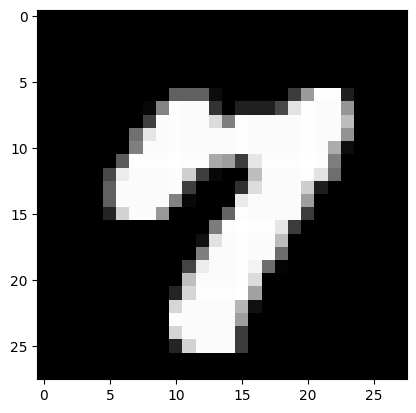

In [5]:
#Generating a random number
i=np.random.randint(0,60000)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray')

In [6]:
#Changing the format ie adding number of channels also
X_train=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [7]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

Hence the pixels are in the range 0 to 255. So we need to normalize the data

In [9]:
X_train=(X_train-127.5)/127.5 #here we are normalizing in the range -1 to 1 inorder to give better results

In [10]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [11]:
#Initialising variables
buffer_size=60000
batch_size=256

In [12]:
type(X_train)

numpy.ndarray

In [13]:
#converting it to tensorflow format
X_train=tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [14]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [15]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### Building the generator

In [16]:
def build_generator():
  network=tf.keras.Sequential()
  network.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,))) #Here we adds a fully connected layer with 12544 neurons to the GAN generator, transforming a 100-dimensional input vector (latent space) into an intermediate representation for reshaping and image generation, without using a bias term.
  network.add(layers.BatchNormalization()) #Here we are normalizing the values in hidden layer
  network.add(layers.LeakyReLU()) #here we are using a different activation function recommended by GAN called leakyReLU simialr to ReLU function
  network.add(layers.Reshape((7,7,256))) #here we are reshaping the layer from vector format to tensor format

  #7x7x128
  network.add(layers.Conv2DTranspose(128,(5,5),padding='same',use_bias=False))
  network.add(layers.BatchNormalization()) #Here we are normalizing the values in hidden layer
  network.add(layers.LeakyReLU())

  #14x14x64
  network.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  network.add(layers.BatchNormalization()) #Here we are normalizing the values in hidden layer
  network.add(layers.LeakyReLU())

  #28x28x1
  network.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

  network.summary()
  return network


In [17]:
generator=build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [18]:
noise=tf.random.normal([1,100])

In [19]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.80770415, -0.56948954,  0.37382987,  0.6553801 , -1.2510427 ,
        -1.1664997 , -1.7210971 ,  0.18964715,  0.5189582 ,  1.4257754 ,
        -0.14460829, -0.82311004,  1.428761  ,  0.64123124, -0.39183086,
         0.57147926, -0.3567491 , -1.2147411 ,  0.15967846,  0.43349844,
        -0.1982243 ,  1.4235135 ,  0.6751756 , -0.50868976,  1.9821779 ,
        -1.007412  , -1.3658102 ,  0.48960736, -1.4781406 ,  0.30532485,
         0.0073868 ,  0.9440774 ,  0.7661756 , -0.11625507, -1.2057434 ,
        -1.0109901 ,  1.0309423 , -0.104916  ,  1.6260413 , -0.05962109,
         0.7600416 ,  0.33829853,  0.3080371 ,  0.93239003,  0.49306068,
         1.2150459 ,  0.4711026 ,  1.3327409 , -0.12968086, -0.44027516,
         0.7856731 ,  0.42470616,  0.05709297, -0.59102285,  1.7764863 ,
         1.1845386 ,  0.29114574,  1.3316188 ,  0.03599945,  1.4647557 ,
         0.52715755, -1.022196  , -1.5882187 ,  0.47156212,  0.45253053,
 

In [20]:
#now we are sending the random numbers to the layer we defined
generated_image=generator(noise,training=False)

In [21]:
generated_image.shape


TensorShape([1, 28, 28, 1])

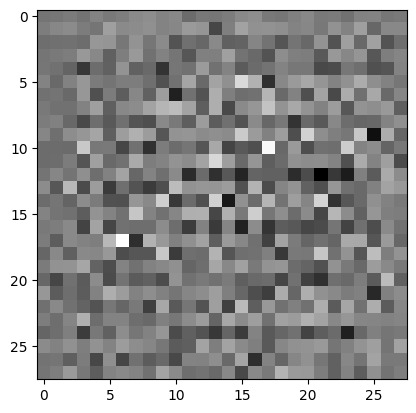

In [22]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

### Building the discriminator

In [23]:
def build_discriminator():
  network=tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network




In [24]:
discriminator=build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
discriminator(generated_image,training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00221259]], dtype=float32)>

Here, we get such a number as result because we don't even trained our dataset yet

### Calculating the loss

In [26]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(expected_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(expected_output),expected_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss #inorder to calculate the error of discriminator

In [28]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [29]:
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)

### Training the model

In [30]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [31]:
epochs=20
noise_dim=100
num_images_to_generate=16

In [32]:
batch_size,noise_dim

(256, 100)

In [33]:
@tf.function
def train_steps(images):
  noise=tf.random.normal([batch_size,noise_dim])
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    expected_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    #To calculate the loss of generator and discriminator
    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(expected_output,fake_output)

  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [34]:
test_images=tf.random.normal([num_images_to_generate,noise_dim])

In [35]:
test_images.shape

TensorShape([16, 100])

In [36]:
def train(dataset,epochs,test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_steps(image_batch) #here we are sending images as seperate batches for training
    print('Epoch:',epoch+1)
    generated_images=generator(test_images,training=False)
    #Here we are displaying result after each one of epochs
    fig=plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i,:,:,0]*127.5+127.5,cmap='gray')
      plt.axis('off')
    plt.show()


Epoch: 1


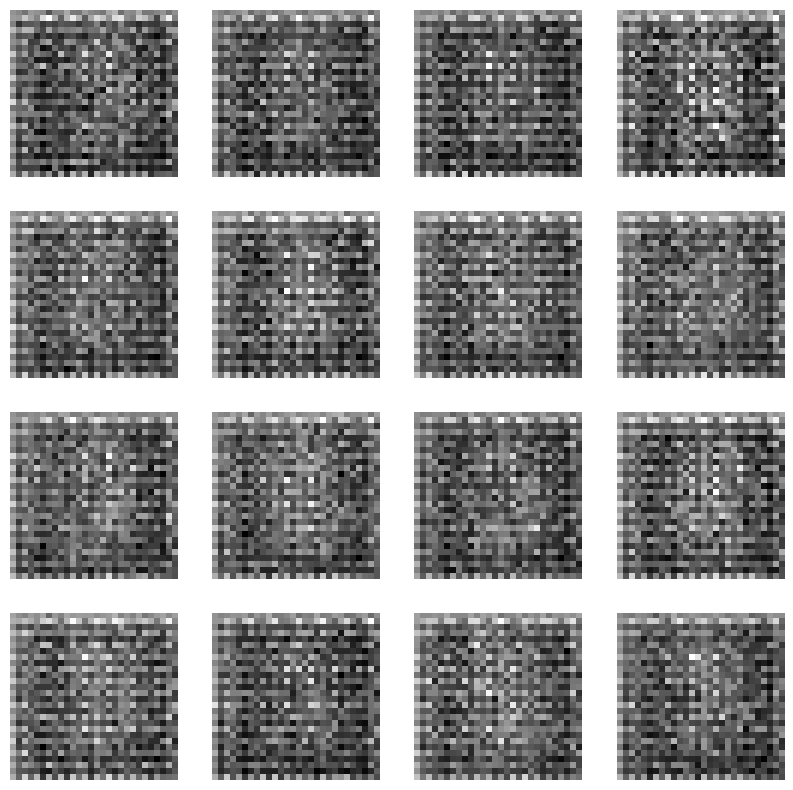

Epoch: 2


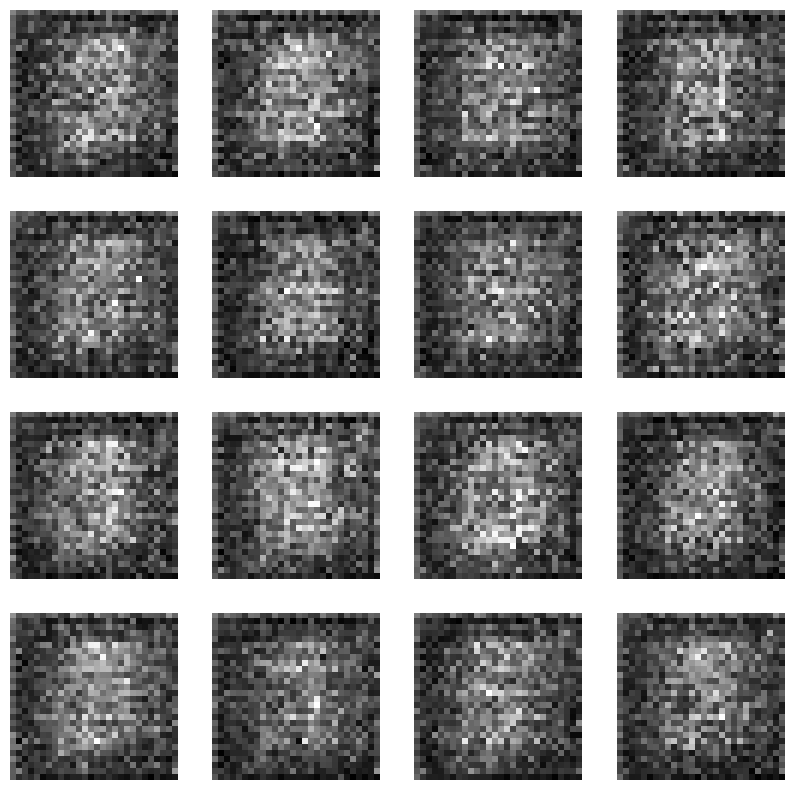

Epoch: 3


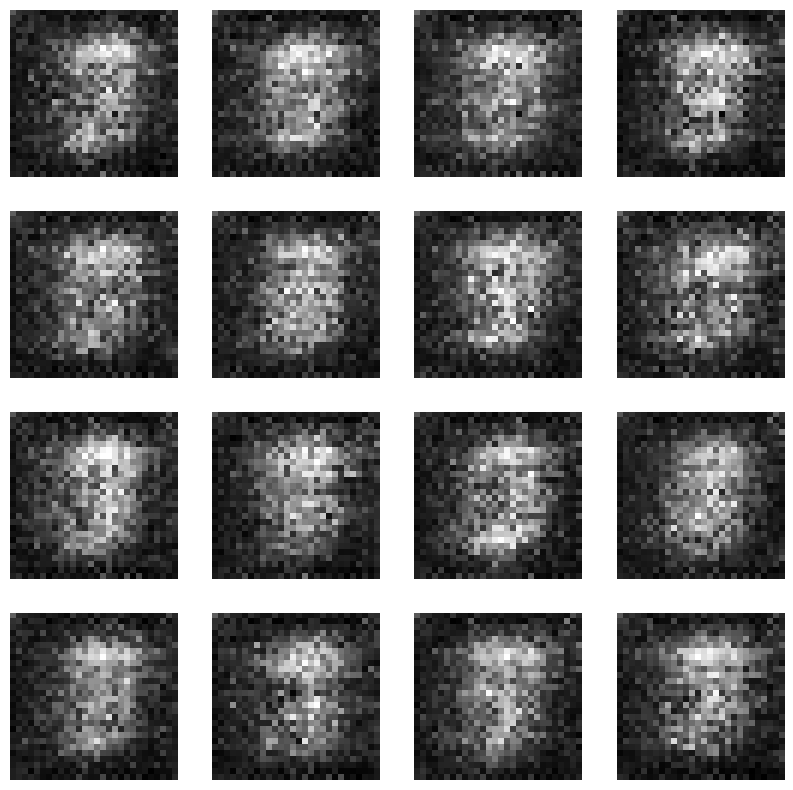

Epoch: 4


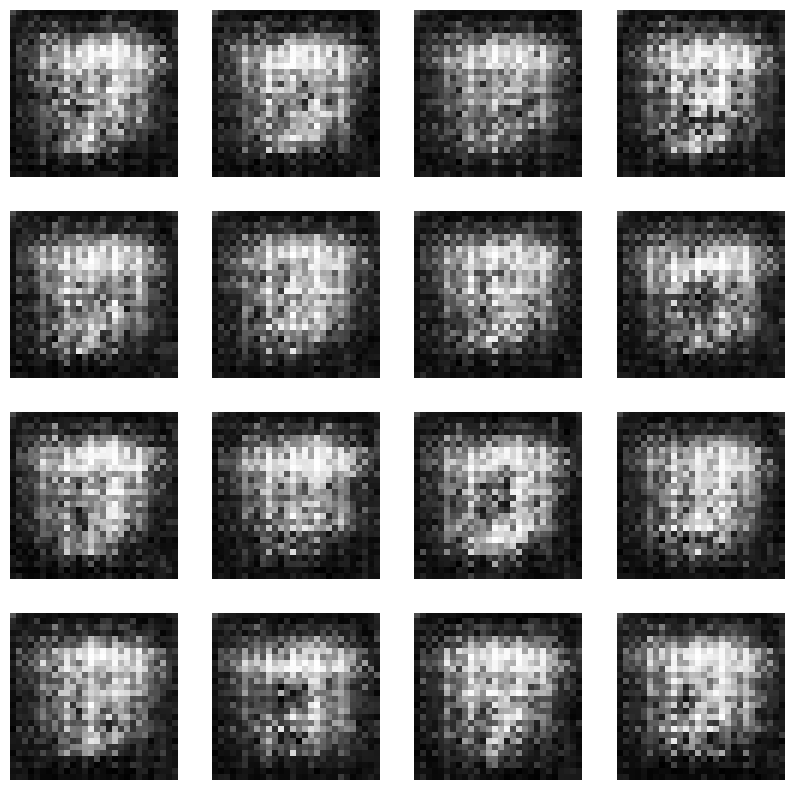

Epoch: 5


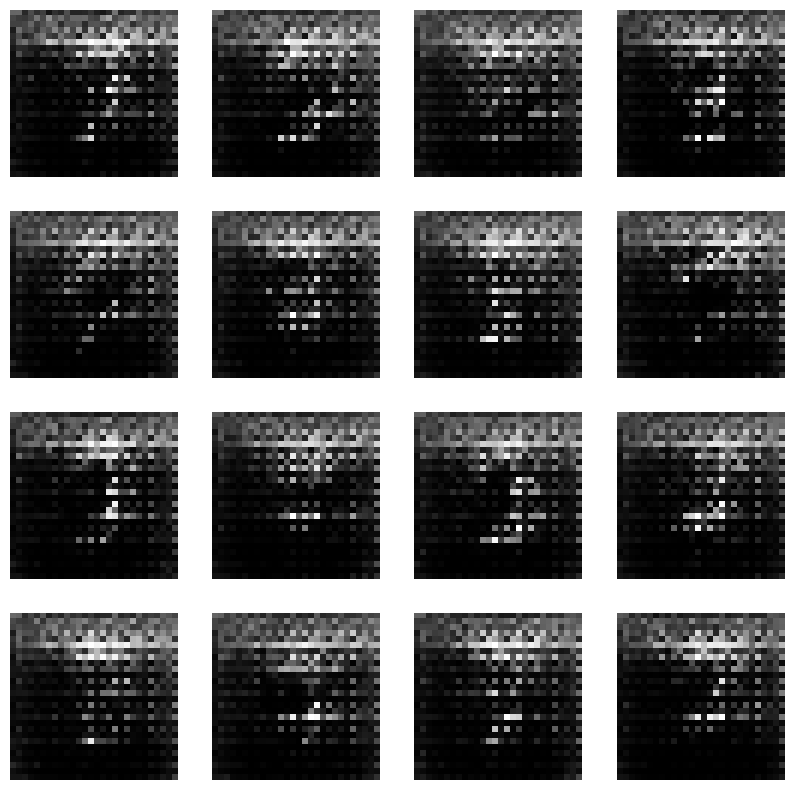

Epoch: 6


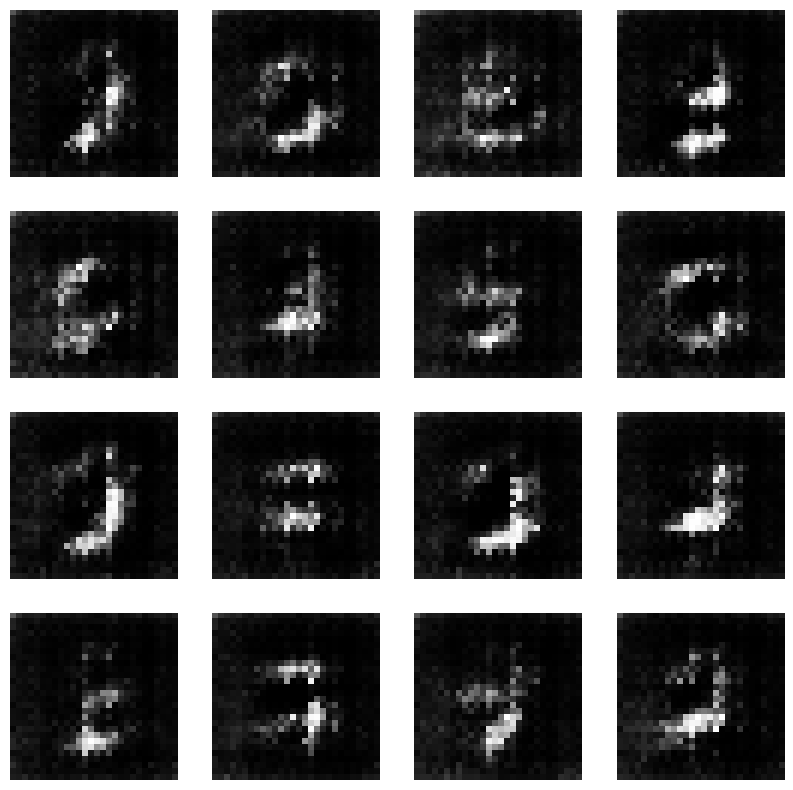

Epoch: 7


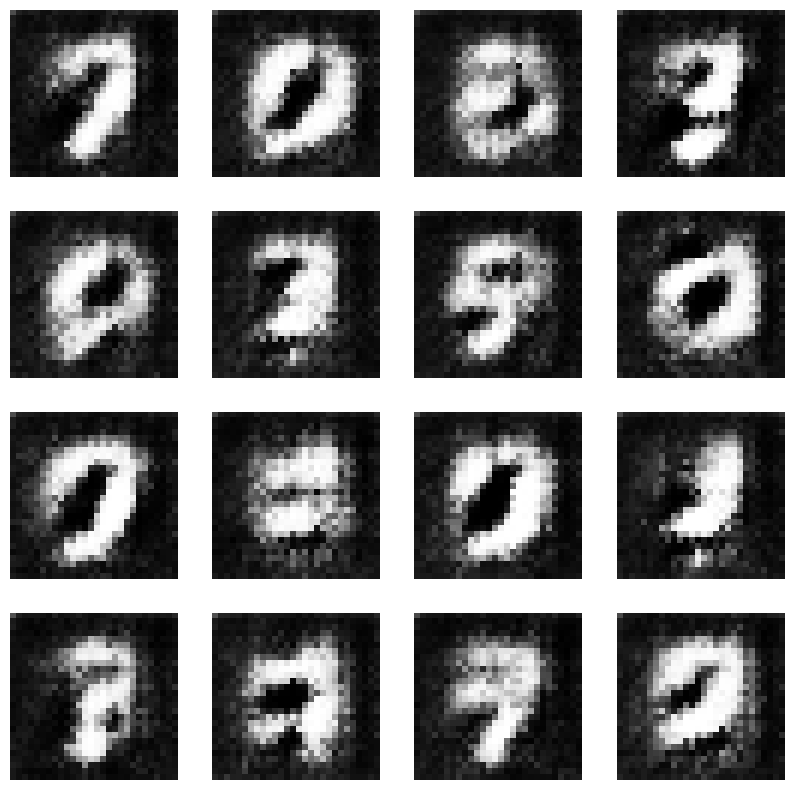

Epoch: 8


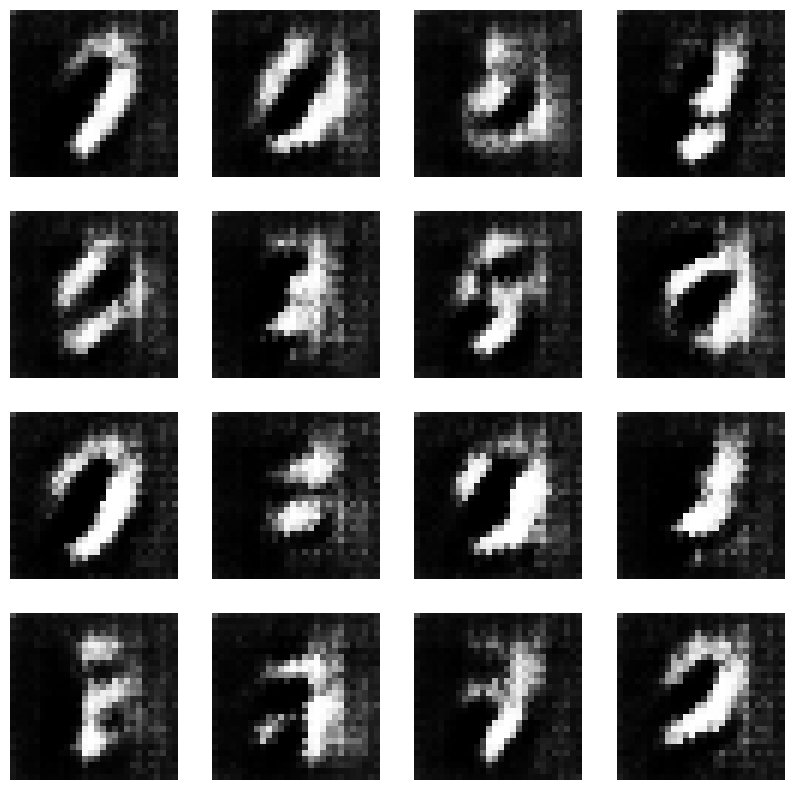

Epoch: 9


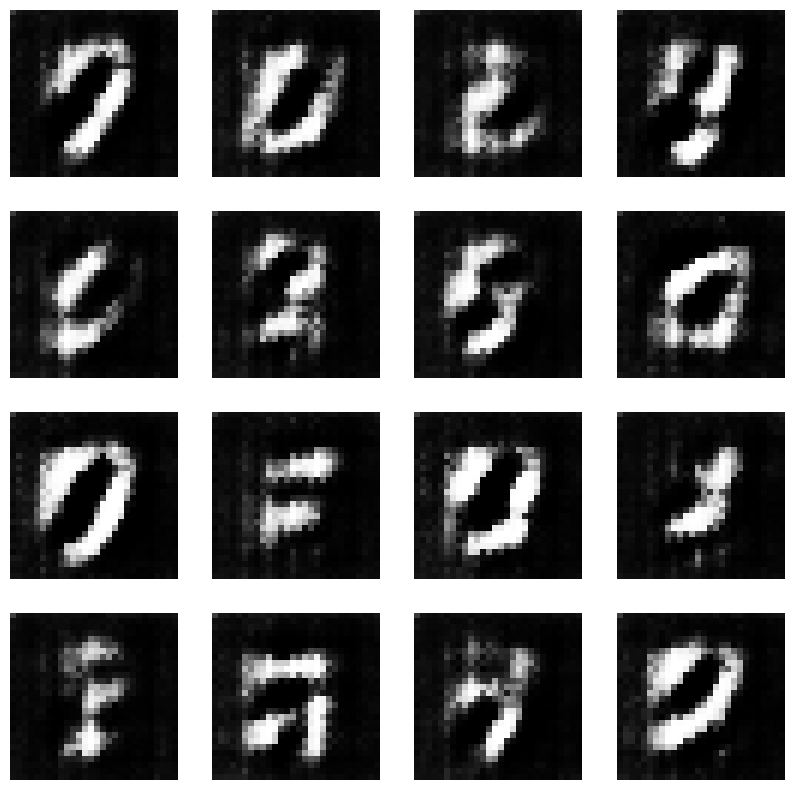

Epoch: 10


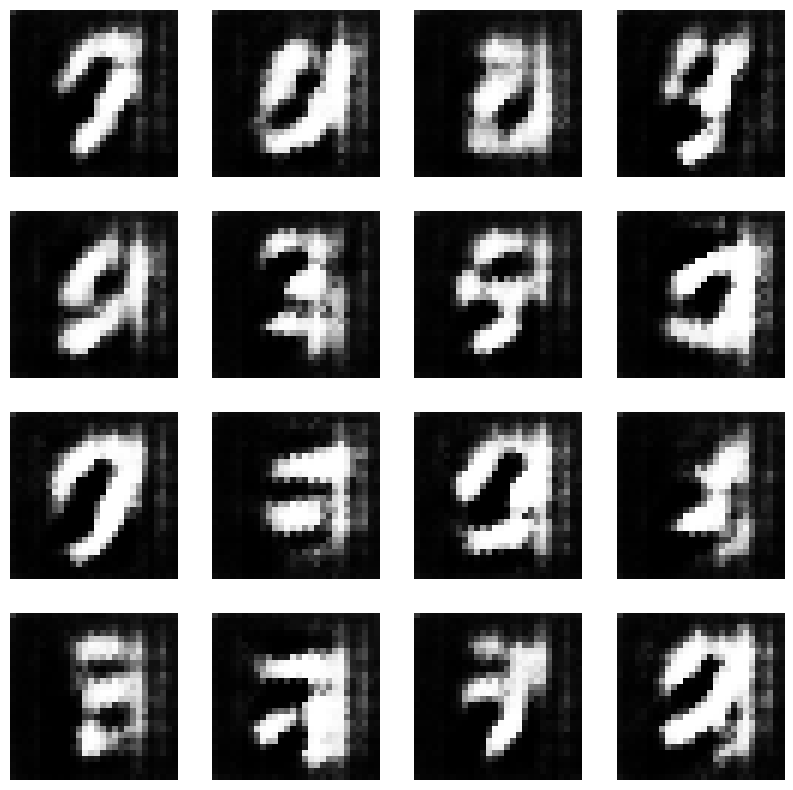

Epoch: 11


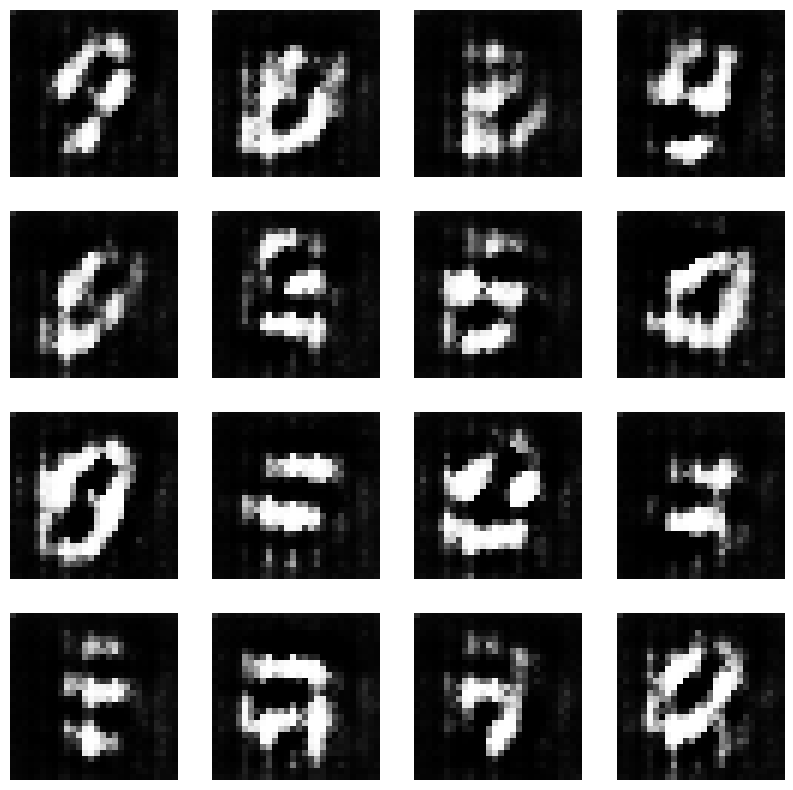

Epoch: 12


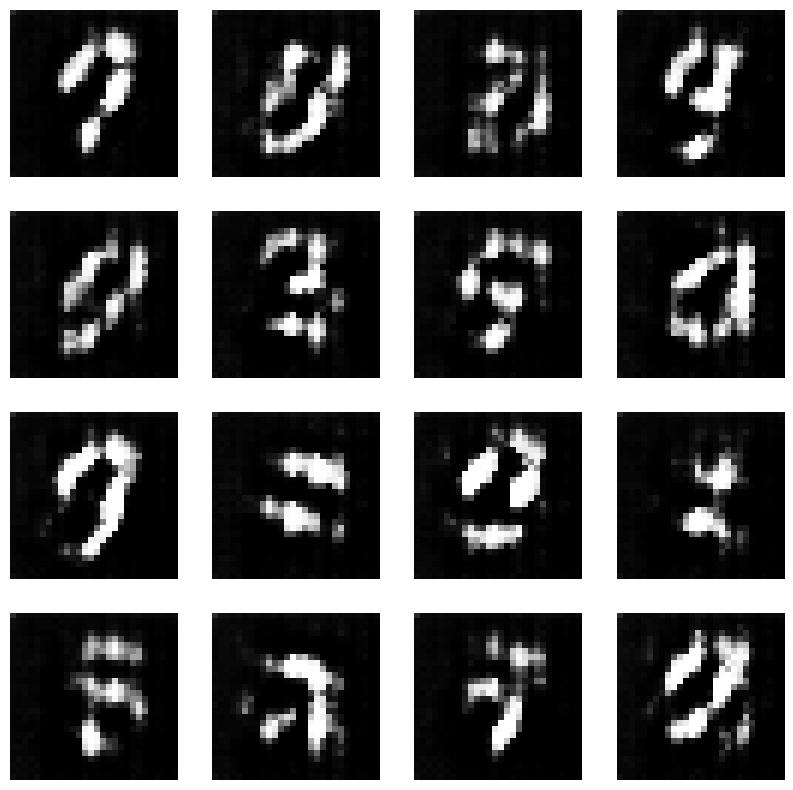

Epoch: 13


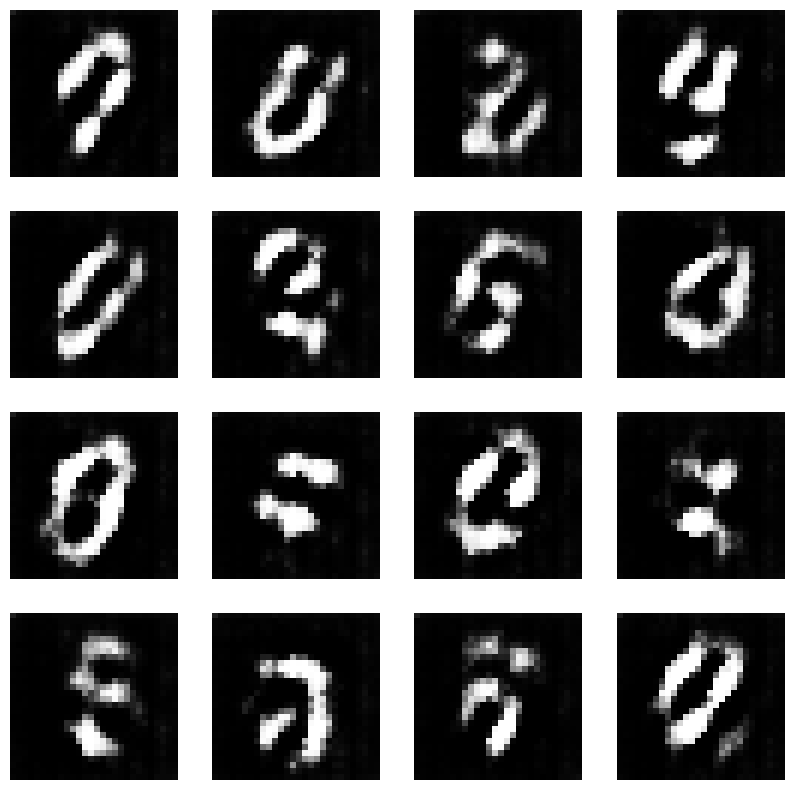

Epoch: 14


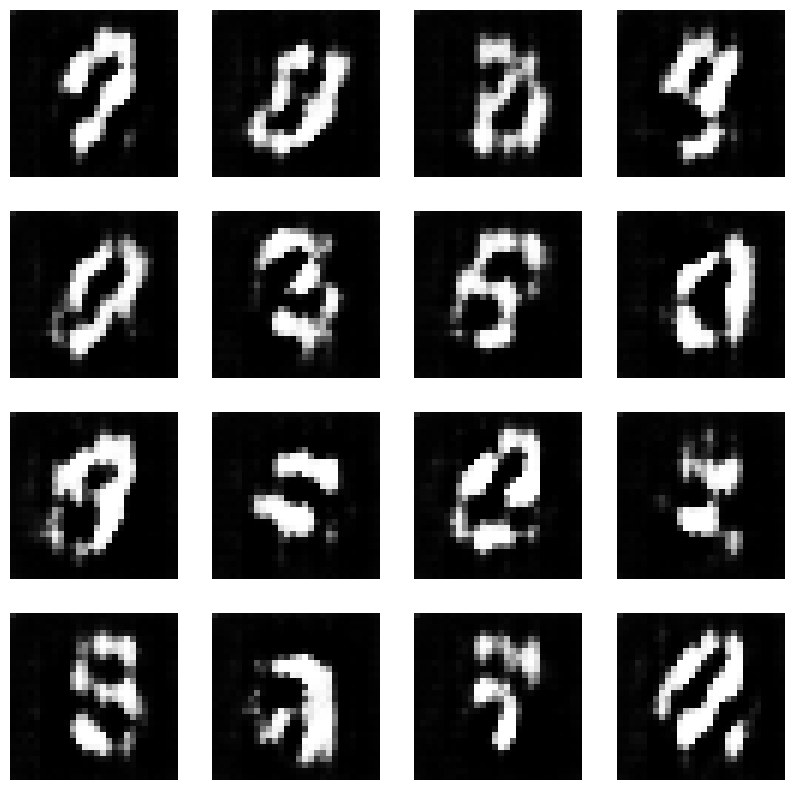

Epoch: 15


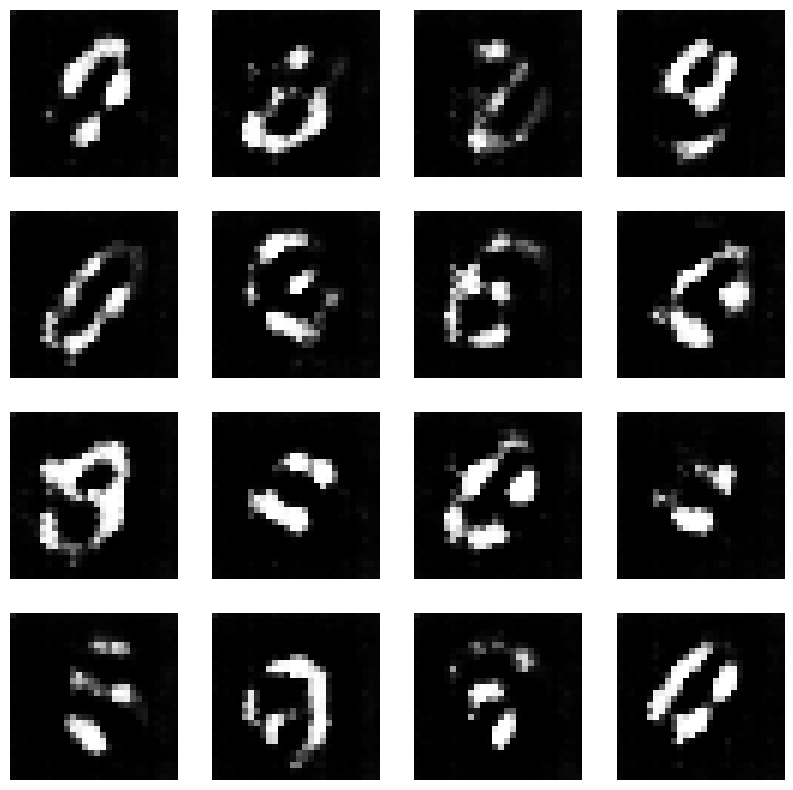

Epoch: 16


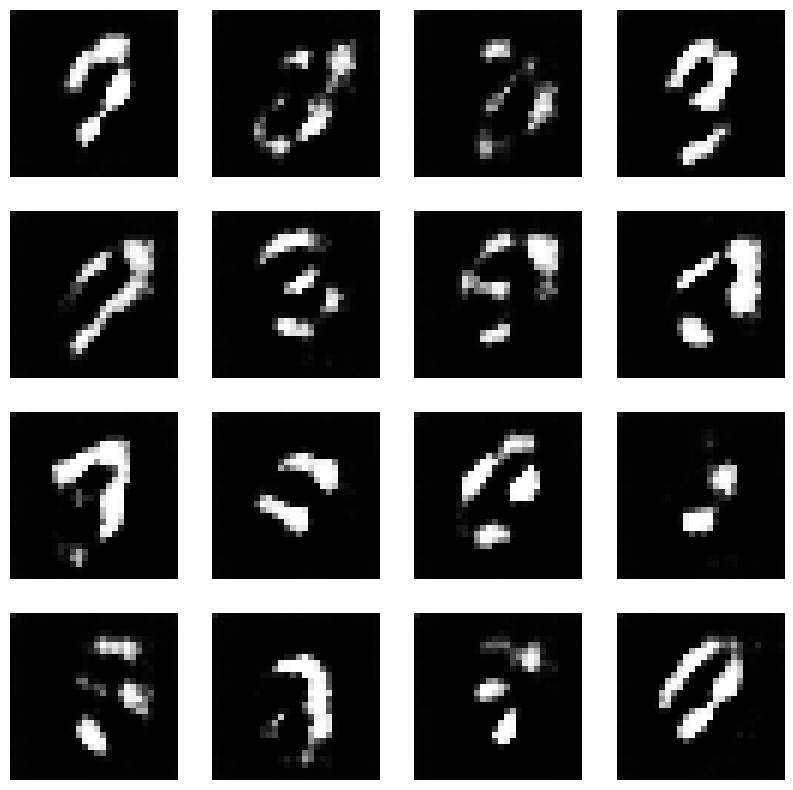

Epoch: 17


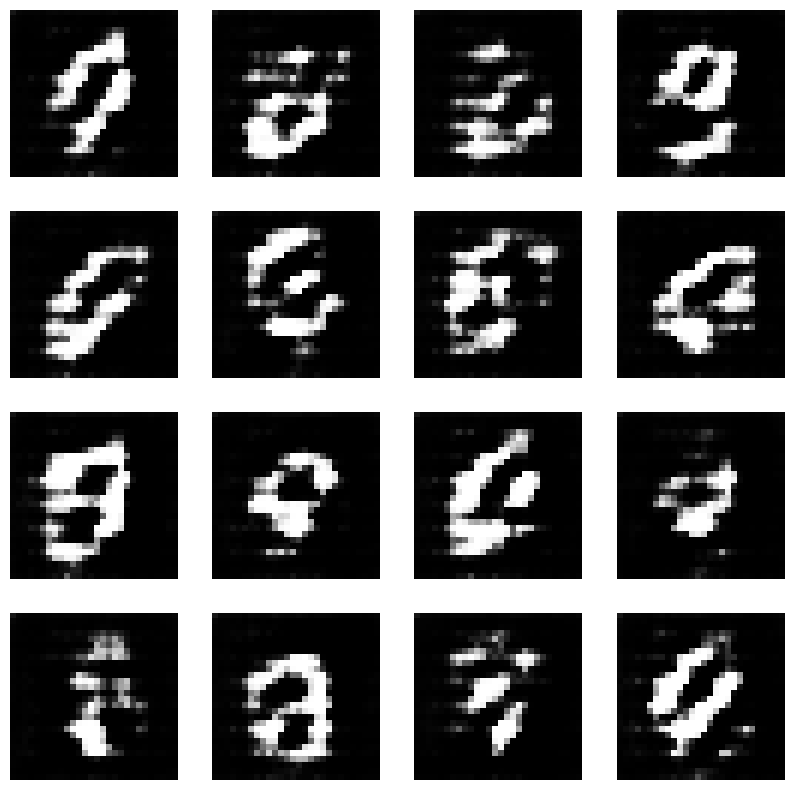

Epoch: 18


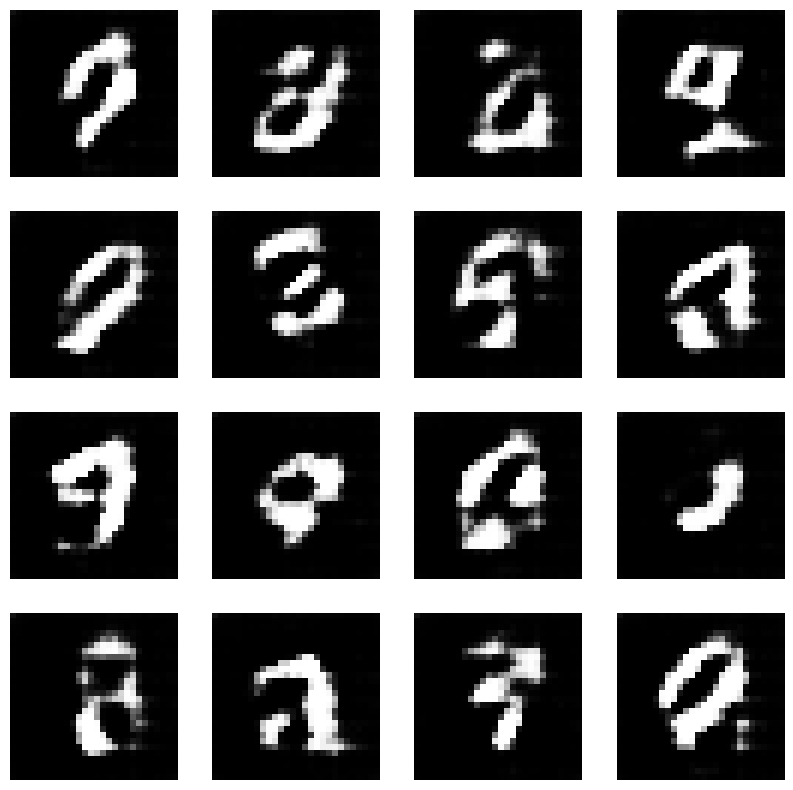

Epoch: 19


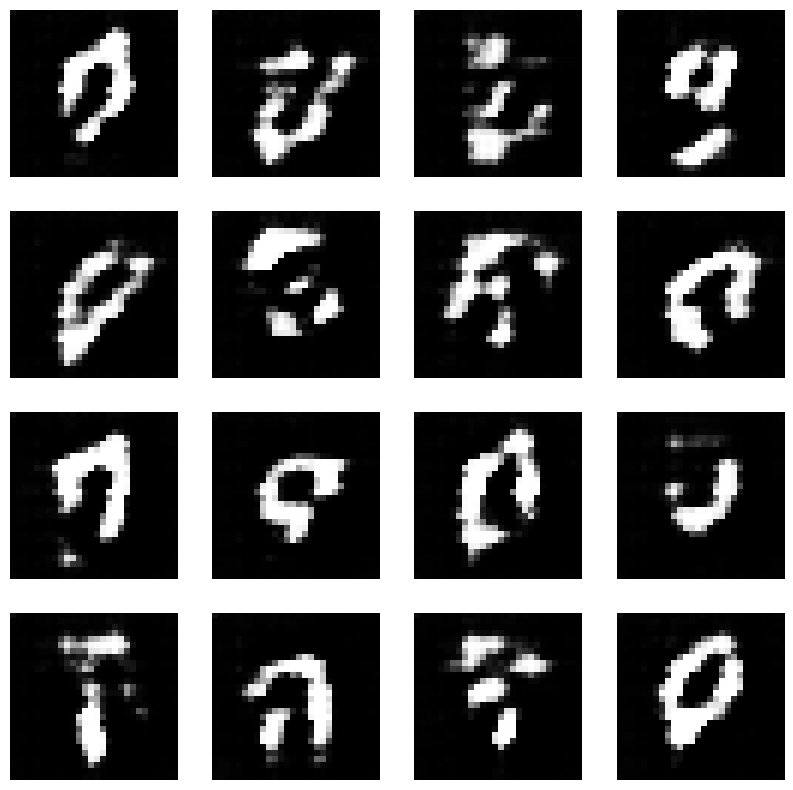

Epoch: 20


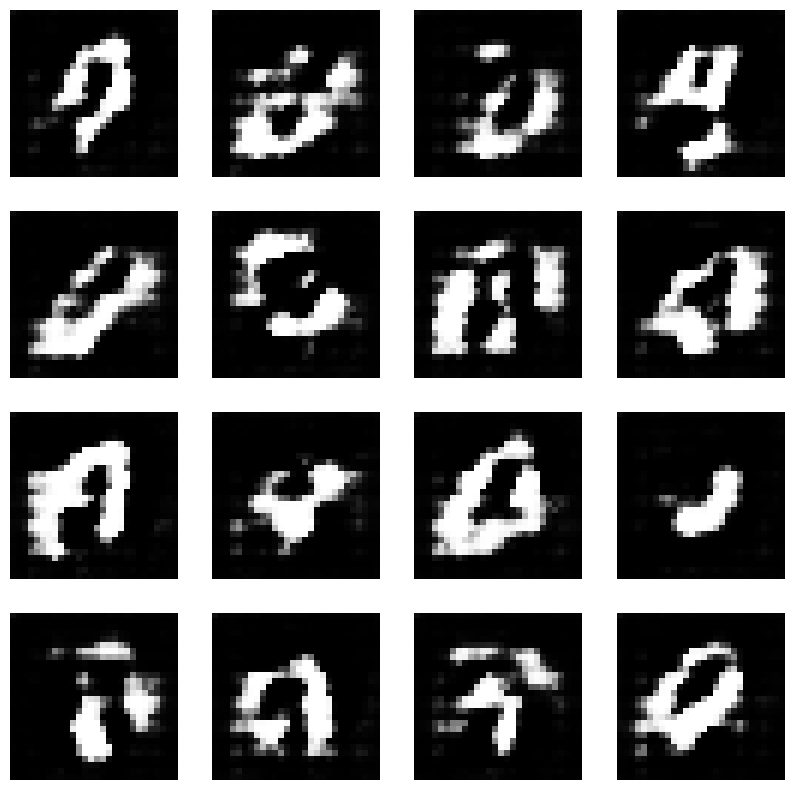

In [37]:
train(X_train,epochs,test_images)

After 20 epochs, most of the generated images become recognizable, and running the model for additional epochs can further improve the quality and realism of the results.